In [1]:
#from sklearn.preprocessing import StandardScaler
import calendar
from math import sqrt
import statistics as st
from scipy.stats import pearsonr
from scipy.spatial.distance import euclidean
from scipy.stats import energy_distance
import pvlib
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
import numpy as np
import os
import json
from typing import Optional
import scipy
import matplotlib.dates as mdates
from collections import OrderedDict

MONTANA_ENERGY=[31.82001509061525, -106.21586560346859]
FORTBLISS_ENERGY=[31.82999, -106.37286]
CAMS49=[31.6675435,-106.2879750]

file_path=r"C:\Users\lehri\Documents\GitHub\dust_solar_power"
file_montana_solar=os.path.join(file_path,"Montana_Solar_Facility_net_generation.csv")
file_fortbliss_solar=os.path.join(file_path,"Fort_Bliss_(DEA_EPIC)_net_generation.csv")
montana_energy_mw=pd.read_csv(file_montana_solar, header=[4], index_col=0,engine="python")
fortbliss_energy_mw=pd.read_csv(file_fortbliss_solar, header=[4], index_col=0, engine="python")

with open(os.path.join(file_path,'keys.json')) as f:
    d = json.load(f)
    api_key=d['api_key']
    email=d['email']

In [2]:
#Finding the appropriate solar modules for both locations based on satellite imagery and data found online
cec_modules=pd.read_csv(os.path.join(file_path,"CEC_Modules.csv"), header=[0],skiprows=[1,2])
cec_modules
cec_modules_cdte=cec_modules[cec_modules['Technology']=='CdTe']
cec_modules_cdte=cec_modules_cdte[cec_modules_cdte["Manufacturer"]=='First Solar Inc.']

cec_modules_cSi=cec_modules[cec_modules['Technology']=='Mono-c-Si']
cec_modules_cSi[cec_modules_cSi["Length"].notna()]
cec_modules_cSi=cec_modules_cSi[cec_modules_cSi["Length"]<=1.7]
cec_modules_cSi=cec_modules_cSi[cec_modules_cSi["Length"]>1.6]
cec_modules_cSi=cec_modules_cSi[cec_modules_cSi["Width"]<=1.0]
cec_modules_cSi=cec_modules_cSi[cec_modules_cSi["Width"]>0.99]
cec_modules_cSi=cec_modules_cSi[cec_modules_cSi["Manufacturer"]=='Jinko Solar Co. Ltd']
#cec_modules_cSi
#cec_modules_cdte

In [3]:
cec_inverters=pd.read_csv(os.path.join(file_path,"CEC_Inverters.csv"), header=[0],skiprows=[1,2])
cec_inverters=cec_inverters[cec_inverters['Pdco']<27500]
cec_inverters=cec_inverters[cec_inverters['Pdco']>25000]
cec_inverters

,Name,Vac,Pso,Paco,Pdco,Vdco,C0,C1,C2,C3,Pnt,Vdcmax,Idcmax,Mppt_low,Mppt_high,CEC_Date,CEC_hybrid
188,CSI Solar Co - Ltd : CSI-25K-T480GL01-UB [480V],480,28.9305,24958.0,25377.7,470.0,-2.441600e-07,-4.976690e-07,0.000519,0.000650,1.0,800.0,53.9951,347.0,800.0,12/1/2021,N
189,CSI Solar Co - Ltd : CSI-25KTL-GS-FLB [480V],480,68.8259,25000.0,25568.0,650.0,-3.729170e-07,1.672410e-05,-0.000736,0.001291,14.0,770.0,39.3353,580.0,770.0,12/1/2021,N
210,Canadian Solar Inc : CSI-25KTL-GS-FL [480V],480,65.3352,25000.0,25581.9,650.0,-3.961770e-07,1.350590e-05,0.000622,0.002894,14.0,780.0,39.3568,580.0,780.0,11/15/2019,N
231,Chint Power Systems America: CPS SCA25KTL-DO-R...,480,37.6542,25000.0,25548.1,735.0,-4.006700e-07,-2.672780e-05,-0.001418,-0.001992,3.0,850.0,34.7593,560.0,850.0,6/13/2022,N
232,Chint Power Systems America: CPS SCA25KTL-DO/U...,208,79.0357,25000.0,25971.3,575.0,-6.615420e-07,1.591300e-05,0.001805,0.000251,2.9,850.0,45.1676,480.0,850.0,2/1/2023,N
294,Delta Electronics: M24U_120 [480V],480,69.9273,26403.0,26885.2,710.0,-2.520400e-07,-2.744700e-05,-0.001203,-0.000930,2.6,830.0,37.8664,415.0,830.0,3/2/2020,N
295,Delta Electronics: M24U_121 [480V],480,69.9273,26403.0,26885.2,710.0,-2.520400e-07,-2.744700e-05,-0.001203,-0.000930,2.6,830.0,37.8664,415.0,830.0,3/2/2020,N
296,Delta Electronics: M24U_122 [480V],480,69.9273,26403.0,26885.2,710.0,-2.520400e-07,-2.744700e-05,-0.001203,-0.000930,2.6,830.0,37.8664,415.0,830.0,3/2/2020,N
646,Ginlong Technologies Co - Ltd : Solis-25K-US [...,480,65.3352,25000.0,25581.9,650.0,-3.961770e-07,1.350590e-05,0.000622,0.002894,14.0,780.0,39.3568,580.0,780.0,11/15/2019,N
647,Ginlong Technologies Co - Ltd : Solis-25K-US-L...,480,28.9305,24958.0,25377.7,470.0,-2.441600e-07,-4.976690e-07,0.000519,0.000650,1.0,800.0,53.9951,347.0,800.0,NaN,N


In [4]:
# Retrieve the CEC inverter database
cec_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')
# Search for an inverter by part of its name (e.g., 'SMA' for SMA inverters)
filtered_inverters = cec_inverters.filter(like='Canadian_Solar_Inc___CSI_25KTL_GS_FL__480V_', axis=1)
print(filtered_inverters.columns)

Index(['Canadian_Solar_Inc___CSI_25KTL_GS_FL__480V_'], dtype='object')


In [5]:
# Retrieve the CEC inverter database
cec_modules = pvlib.pvsystem.retrieve_sam('cecmod')
# Search for an inverter by part of its name (e.g., 'SMA' for SMA inverters)
filtered_modules = cec_modules.filter(like='AS_6M_350W', axis=1)
print(filtered_modules.columns)

Index(['Amerisolar_Worldwide_Energy_and_Manufacturing_USA_Co___Ltd_AS_6M_350W'], dtype='object')


In [6]:
print(montana_energy_mw['Dec 2021':'Jan 2019'].isna().sum())
montana_energy_mw=montana_energy_mw['Dec 2021':'Jan 2019'].dropna()
montana_energy_mw = montana_energy_mw.rename(columns={'All primemovers - All fuels (ALL) megawatthours': 'Actual Production'})
fortbliss_energy_mw=fortbliss_energy_mw['Dec 2021':'Jan 2019'].dropna()
fortbliss_energy_mw = fortbliss_energy_mw.rename(columns={'All primemovers - All fuels (ALL) megawatthours': 'Actual Production'})

All primemovers - All fuels (ALL) megawatthours    30
dtype: int64


In [7]:
montana_energy_mw.index= pd.to_datetime(montana_energy_mw.index, format='%b %Y')
montana_energy_mw=montana_energy_mw.sort_values(by=['Month'])

fortbliss_energy_mw.index=pd.to_datetime(fortbliss_energy_mw.index, format='%b %Y')
fortbliss_energy_mw=fortbliss_energy_mw.sort_values(by=['Month'])

C:\Users\lehri\AppData\Local\Temp\ipykernel_4556\1409294530.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_range=pd.date_range(start='2019-01-01', end='2022-01-01', freq='M')


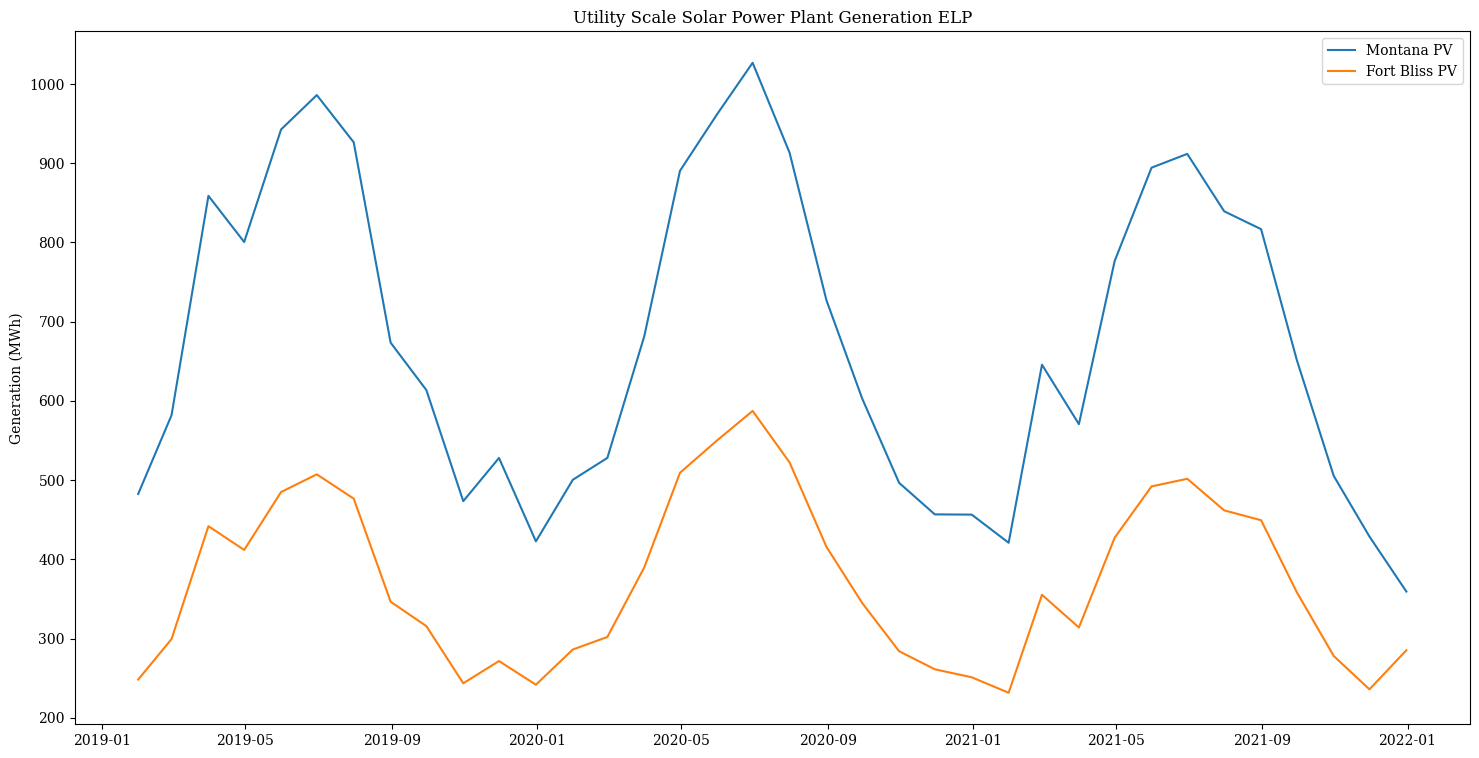

In [8]:
date_range=pd.date_range(start='2019-01-01', end='2022-01-01', freq='M')
#date_range.shape is 36
plt.subplots(figsize=(18, 9))
plt.title("Utility Scale Solar Power Plant Generation ELP")
plt.plot(date_range, montana_energy_mw.values.flatten(), label='Montana PV')
plt.plot(date_range, fortbliss_energy_mw.values.flatten(), label='Fort Bliss PV')
plt.ylabel("Generation (MWh)")
plt.legend()
plt.show()

In [9]:
%store -r mar_all
%store -r mar_all_clean

In [10]:
#Example from https://pvlib-python.readthedocs.io/en/stable/gallery/system-models/plot_oedi_9068.html#sphx-glr-gallery-system-models-plot-oedi-9068-py
def pvsystem_parameters(soiling, latitude, longitude, modules_per_string, strings_per_inverter, num_inverters, module_type, module_technology, inverter_type, 
                        module_width, module_length, module_weight, module_number_vertical, pitch, azimuth, fixed_tilt, fixed_tilt_angle: Optional[float] = None, sr_array: Optional[float] = None):
    

    cec_module_db = pvlib.pvsystem.retrieve_sam('cecmod')
    module_parameters = cec_module_db[module_type]
    module_parameters['Technology'] = module_technology
    # default Faiman model parameters:
    temperature_model_parameters = dict(u0=25.0, u1=6.84)
    module_unit_mass = module_weight / (module_length*module_width) # kg/m^2, taken from datasheet values
    
    cec_inverter_db = pvlib.pvsystem.retrieve_sam('cecinverter')
    inverter_parameters = cec_inverter_db[inverter_type]
    
    # Using PVWatts v5 losses model, set shading, availability and soiling to zero
    # Will define soiling losses separately
    # Leaving the other pvwatts loss types (mismatch, wiring, etc) unspecified
    # causes them to take their default values.
    losses_parameters = dict(shading=0, availability=0, soiling=0)
    gcr = (module_number_vertical * module_width + (module_number_vertical-1) * 0.01) / pitch
    axis_azimuth = azimuth  # degrees
    axis_height = 1.5  # meters

    location = pvlib.location.Location(latitude, longitude)
    if fixed_tilt==False:
        # The tracker rotation measurements reveal that the tracker rotation limits
        # are +/- 60 degrees, and backtracking is not enabled:
        max_angle = 60  # degrees
        backtrack = False
        mount = pvlib.pvsystem.SingleAxisTrackerMount(
            gcr=gcr,
            backtrack=backtrack,
            max_angle=max_angle,
            axis_azimuth=axis_azimuth
        )
    else:
        mount = pvlib.pvsystem.FixedMount(
            surface_tilt=fixed_tilt_angle,
            surface_azimuth=azimuth,
            racking_model='open-rack',
            module_height=axis_height
        )
    array = pvlib.pvsystem.Array(
        mount,
        module_parameters=module_parameters,
        modules_per_string=modules_per_string,
        temperature_model_parameters=temperature_model_parameters,
        strings=strings_per_inverter
    )
    system = pvlib.pvsystem.PVSystem(
        array,
        inverter_parameters=inverter_parameters,
        losses_parameters=losses_parameters
    )
    
    model = pvlib.modelchain.ModelChain(
        system,
        location,
        spectral_model='first_solar',
        aoi_model='physical',
        losses_model='pvwatts'
    )

    pvlib_models_df_2019=pd.DataFrame()
    pvlib_models_df_2020=pd.DataFrame()
    pvlib_models_df_2021=pd.DataFrame()
    keys = ['ghi', 'dni', 'dhi', 'temp_air', 'wind_speed',
        'albedo', 'precipitable_water']
    for year in [2019,2020,2021]:
        
        psm3, psm3_metadata = pvlib.iotools.get_psm3(latitude, longitude, api_key,
                                                     email, interval=5, names=year,
                                                     map_variables=True, leap_day=True,
                                                     attributes=keys)
        solar_position = location.get_solarposition(psm3.index, latitude, longitude)
        tracker_angles = mount.get_orientation(
            solar_position['apparent_zenith'],
            solar_position['azimuth']
        )
        dni_extra = pvlib.irradiance.get_extra_radiation(psm3.index)
        
        averaged_irradiance = pvlib.bifacial.infinite_sheds.get_irradiance_poa(
            tracker_angles['surface_tilt'], tracker_angles['surface_azimuth'],
            solar_position['apparent_zenith'], solar_position['azimuth'],
            gcr, axis_height, pitch,
            psm3['ghi'], psm3['dhi'], psm3['dni'], psm3['albedo'],
            model='haydavies', dni_extra=dni_extra,
        )
        cell_temperature_steady_state = pvlib.temperature.faiman(
        poa_global=averaged_irradiance['poa_global'],
        temp_air=psm3['temp_air'],
        wind_speed=psm3['wind_speed'],
        **temperature_model_parameters,
        )
        
        cell_temperature = pvlib.temperature.prilliman(
            cell_temperature_steady_state,
            psm3['wind_speed'],
            unit_mass=module_unit_mass
        )
        weather_inputs = pd.DataFrame({
        'poa_global': averaged_irradiance['poa_global'],
        'poa_direct': averaged_irradiance['poa_direct'],
        'poa_diffuse': averaged_irradiance['poa_diffuse'],
        'cell_temperature': cell_temperature,
        'precipitable_water': psm3['precipitable_water'],  # for the spectral model
        })
        model.run_model_from_poa(weather_inputs)
        #If the modules, mounting, stringing, and inverters are all identical for each inverter, 
        #then you may simply simulate one inverter and multiply the ModelChainResult.ac by the number of inverters to get the total system output.
        #ac_output = model.results.ac
        ac_output = model.results.ac.resample('1h').mean()
        if soiling==True:
            sr=sr_array[year-2019]['SR'].to_numpy()
            #daily_soiling_losses should be taken from rate of soiling estimation made based on PM and dustscore
            #a Series of percentagesper day
            daily_soiling_losses=sr
            ac_output = ac_output * daily_soiling_losses
            
        if year==2019:
            pvlib_models_df_2019['model'] = ac_output / 1000 / 1000 * num_inverters# convert W to MW
        elif year==2020:
            pvlib_models_df_2020['model'] = ac_output / 1000 / 1000 * num_inverters# convert W to MW
        else:
            pvlib_models_df_2021['model'] = ac_output / 1000 / 1000 * num_inverters# convert W to MW
            
    return pvlib_models_df_2019, pvlib_models_df_2020, pvlib_models_df_2021, model

<h3>Montana Energy PVlib Model<h3>

<h3>Fort Bliss PVlib Model<h3>

In [11]:
fort_module_pitch=5.8
fort_module_width=0.99
fort_module_length=1.8
fort_module_weight=12
fort_module_number_vertical=2
fort_modules_per_string=18
fort_strings_per_inverter=4
fort_num_inverters=102
#fort_module_type='Jinko_Solar_Co___Ltd_JKM300M_72'
fort_module_type='Amerisolar_Worldwide_Energy_and_Manufacturing_USA_Co___Ltd_AS_6M_350W'
#fort_inverter_type='SunPower__SPR_20000m_3_H__480V_'
fort_inverter_type='Canadian_Solar_Inc___CSI_25KTL_GS_FL__480V_'
fort_module_technology="Mono-c-Si"
fort_fixed_tilt=15
#most optimal tilt angle was found to be 27
fort_azimuth=179


In [12]:
fort_pvlib_models_2019_soiling, fort_pvlib_models_2020_soiling, fort_pvlib_models_2021_soiling, fort_model_soiling= pvsystem_parameters(True,FORTBLISS_ENERGY[0], FORTBLISS_ENERGY[1], fort_modules_per_string, 
                                                                                                                                        fort_strings_per_inverter, fort_num_inverters, fort_module_type, 
                                                                                                                                        fort_module_technology, fort_inverter_type, fort_module_width, fort_module_length, 
                                                                                                                                        fort_module_weight, fort_module_number_vertical, fort_module_pitch, fort_azimuth, 
                                                                                                                                        True, fort_fixed_tilt,mar_all)

In [13]:
fort_pvlib_models_2019_soiling_clean, fort_pvlib_models_2020_soiling_clean, fort_pvlib_models_2021_soiling_clean, fort_model_soiling_clean= pvsystem_parameters(True,FORTBLISS_ENERGY[0], FORTBLISS_ENERGY[1], fort_modules_per_string, 
                                                                                                                                        fort_strings_per_inverter, fort_num_inverters, fort_module_type, 
                                                                                                                                        fort_module_technology, fort_inverter_type, fort_module_width, fort_module_length, 
                                                                                                                                        fort_module_weight, fort_module_number_vertical, fort_module_pitch, fort_azimuth, 
                                                                                                                                        True, fort_fixed_tilt,mar_all_clean)

In [14]:
fort_pvlib_models_2019, fort_pvlib_models_2020, fort_pvlib_models_2021, fort_model= pvsystem_parameters(False,FORTBLISS_ENERGY[0], FORTBLISS_ENERGY[1], fort_modules_per_string, 
                                                                                                                                        fort_strings_per_inverter, fort_num_inverters, fort_module_type, 
                                                                                                                                        fort_module_technology, fort_inverter_type, fort_module_width, fort_module_length, 
                                                                                                                                        fort_module_weight, fort_module_number_vertical, fort_module_pitch, fort_azimuth, 
                                                                                                                                        True, fort_fixed_tilt)

In [15]:
fort_pvlib_nosoiling=[fort_pvlib_models_2019,fort_pvlib_models_2020,fort_pvlib_models_2021]
fort_pvlib_soiling=[fort_pvlib_models_2019_soiling,fort_pvlib_models_2020_soiling,fort_pvlib_models_2021_soiling]
fort_pvlib_soiling_clean=[fort_pvlib_models_2019_soiling_clean,fort_pvlib_models_2020_soiling_clean,fort_pvlib_models_2021_soiling_clean]
fort_pvlib_models=[fort_pvlib_nosoiling,fort_pvlib_soiling,fort_pvlib_soiling_clean]
fort_pvlib_models_names=["No Soiling","Soiling","Soiling with Cleaning"]

Fort Bliss Actual 2019:  4289.881
Fort Bliss Actual 2020:  4704.369000000001
Fort Bliss Actual 2021:  4391.115
No Soiling Annual Power Production 2019:  4923.078144800483
No Soiling Annual Power Production 2020:  5109.088450694462
No Soiling Annual Power Production 2021:  5021.035360482472
Fort Bliss Actual 2019:  4289.881
Fort Bliss Actual 2020:  4704.369000000001
Fort Bliss Actual 2021:  4391.115
Soiling Annual Power Production 2019:  4013.082850629276
Soiling Annual Power Production 2020:  3048.7229346746863
Soiling Annual Power Production 2021:  3132.6973546957433
Fort Bliss Actual 2019:  4289.881
Fort Bliss Actual 2020:  4704.369000000001
Fort Bliss Actual 2021:  4391.115
Soiling with Cleaning Annual Power Production 2019:  4503.779087971534
Soiling with Cleaning Annual Power Production 2020:  4607.980343453333
Soiling with Cleaning Annual Power Production 2021:  4542.011362930528


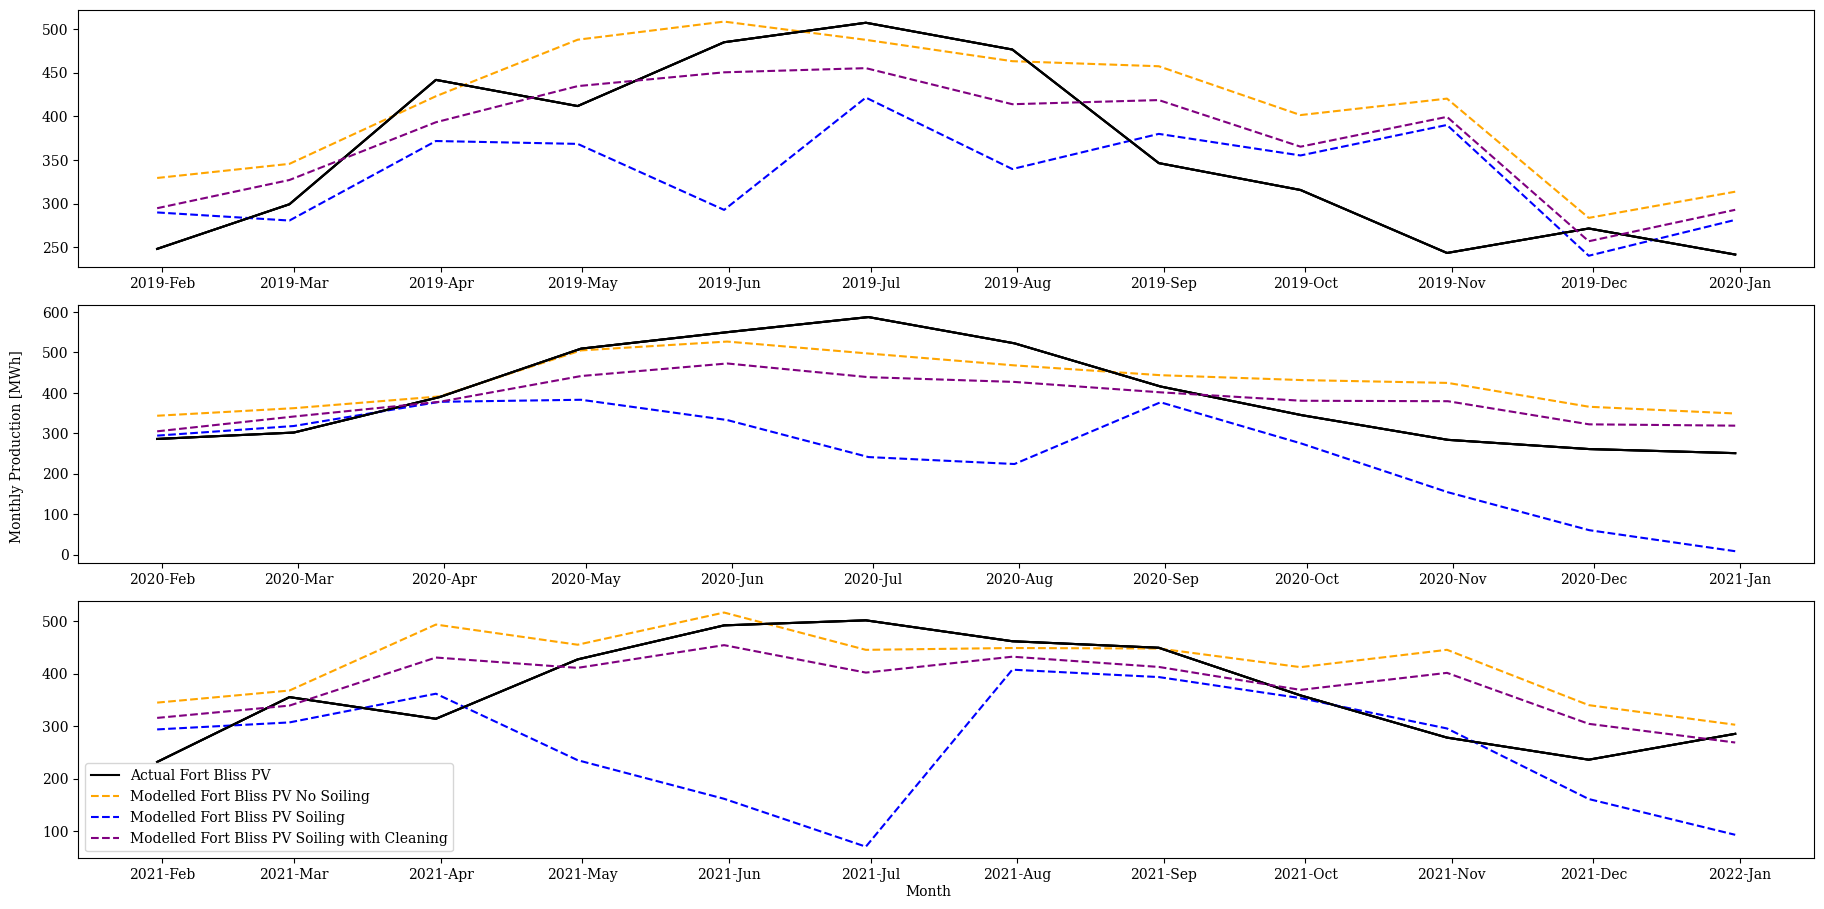

In [16]:

count=0
colors={0:'orange',1:'blue',2:'purple'}
fig, ax = plt.subplots(3,1,figsize=(18, 9))

nosoiling_daily=[]
soiling_daily=[]
soilingclean_daily=[]

nosoiling_hourly=[]
soiling_hourly=[]
soilingclean_hourly=[]

perc_differences=[]
for model in fort_pvlib_models:
    hourly_energy_all=[]
    monthly_energy_all_years=[]
    monthly_energy_actual_all=[]
    daily_energy_all=[]
    
    fort_annual_production_modelled_2019=[]
    fort_annual_production_modelled_2020=[]
    fort_annual_production_modelled_2021=[]

    for year in [2019,2020,2021]:
        date_range_day=pd.date_range(start=f'{year}-01-01', end=f'{year+1}-01-01', freq='D')[:-1]
        date_range_month=pd.date_range(start=f'{year}-01-01', end=f'{year+1}-01-01', freq='ME')
    
        if year==2019:
            hourly_energy_model=model[year-2019].clip(lower=0).resample('h').mean()
            hourly_energy_model=hourly_energy_model.tz_localize(None)
            hourly_energy_model=hourly_energy_model.rename(columns={'model':f'{fort_pvlib_models_names[count]}_{year}'})
            daily_energy_model = hourly_energy_model.resample('1D').sum()
            daily_energy_all.append(daily_energy_model)
            hourly_energy_all.append(hourly_energy_model)
            monthly_energy_model = daily_energy_model.resample('ME').sum()
            fort_annual_production_modelled_2019.append(monthly_energy_model)
        elif year==2020:
            hourly_energy_model=model[year-2019].clip(lower=0).resample('h').mean()
            hourly_energy_model=hourly_energy_model.tz_localize(None)
            hourly_energy_model=hourly_energy_model.rename(columns={'model':f'{fort_pvlib_models_names[count]}_{year}'})
            daily_energy_model = hourly_energy_model.resample('1D').sum()            
            daily_energy_all.append(daily_energy_model)
            hourly_energy_all.append(hourly_energy_model)
            monthly_energy_model = daily_energy_model.resample('ME').sum()
            fort_annual_production_modelled_2020.append(monthly_energy_model)
        else:
            hourly_energy_model=model[year-2019].clip(lower=0).resample('h').mean()
            hourly_energy_model=hourly_energy_model.tz_localize(None)
            hourly_energy_model=hourly_energy_model.rename(columns={'model':f'{fort_pvlib_models_names[count]}_{year}'})
            daily_energy_model = hourly_energy_model.resample('1D').sum()
            daily_energy_all.append(daily_energy_model)
            hourly_energy_all.append(hourly_energy_model)
            monthly_energy_model = daily_energy_model.resample('ME').sum()
            fort_annual_production_modelled_2021.append(monthly_energy_model)

        fort_actual_production=fortbliss_energy_mw[fortbliss_energy_mw.index.year==year]['Actual Production']
        print(f"Fort Bliss Actual {year}: ",fort_actual_production.sum())
        ax[year-2019].plot(date_range_month, fort_actual_production.values.flatten(),color='black', label=f'Actual Fort Bliss PV')
        ax[year-2019].plot(date_range_month,monthly_energy_model,label=f'Modelled Fort Bliss PV {fort_pvlib_models_names[count]}',color=colors[count],linestyle='dashed')           

        ax[year-2019].xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1,13,1)))
        ax[year-2019].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))

        monthly_energy_year=monthly_energy_model#.tz_localize(None)
        monthly_energy_all_years.append(monthly_energy_year.to_numpy().flatten())
        monthly_energy_actual_all.append(fort_actual_production.to_numpy())
    if count==0:
        nosoiling_hourly.append(hourly_energy_all)
        nosoiling_daily.append(daily_energy_all)
    elif count==1:
        soiling_hourly.append(hourly_energy_all)
        soiling_daily.append(daily_energy_all)
    elif count==2:
        soilingclean_hourly.append(hourly_energy_all)
        soilingclean_daily.append(daily_energy_all)
    #calculate the absolute percentage difference between each model and the actual generation data mean for the study period
    perc_difference_model=np.abs(np.mean(monthly_energy_all_years,axis=0)-np.mean(monthly_energy_actual_all,axis=0))/np.mean(monthly_energy_actual_all,axis=0)*100
    perc_differences.append(perc_difference_model)
    print(f"{fort_pvlib_models_names[count]} Annual Power Production 2019: ",np.array(fort_annual_production_modelled_2019).sum())
    print(f"{fort_pvlib_models_names[count]} Annual Power Production 2020: ",np.array(fort_annual_production_modelled_2020).sum())
    print(f"{fort_pvlib_models_names[count]} Annual Power Production 2021: ",np.array(fort_annual_production_modelled_2021).sum())
    count+=1

fig.text(-0.01, 0.5, 'Monthly Production [MWh]', va='center', rotation='vertical')
fig.text(0.5,0,'Month', ha='center')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
fig.tight_layout(pad=1)
    

Total Difference No Soiling:  230.89258774904798
Total Difference Soiling:  289.2539882640136
Total Difference Soiling with Cleaning:  161.49360018080995


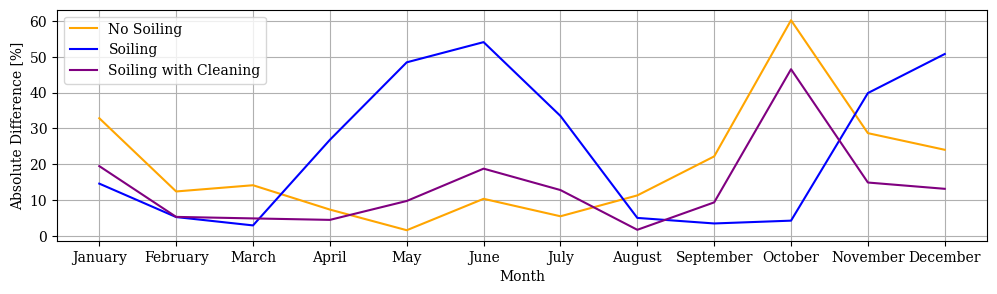

In [17]:

perc_differences=np.array(perc_differences)
fig,ax=plt.subplots(figsize=(12,3))
ax.set_ylabel("Absolute Difference [%]")
ax.set_xlabel("Month")
labels=["No Soiling","Soiling","Soiling with Cleaning"]
for i in range(0,len(perc_differences)):
    ax.plot(perc_differences[i],label=labels[i],color=colors[i])
    plt.xticks(np.arange(12),calendar.month_name[1:])
    print(f"Total Difference {labels[i]}: ",np.sum(perc_differences[i]))
plt.legend(loc="upper left")
plt.grid()
plt.show()

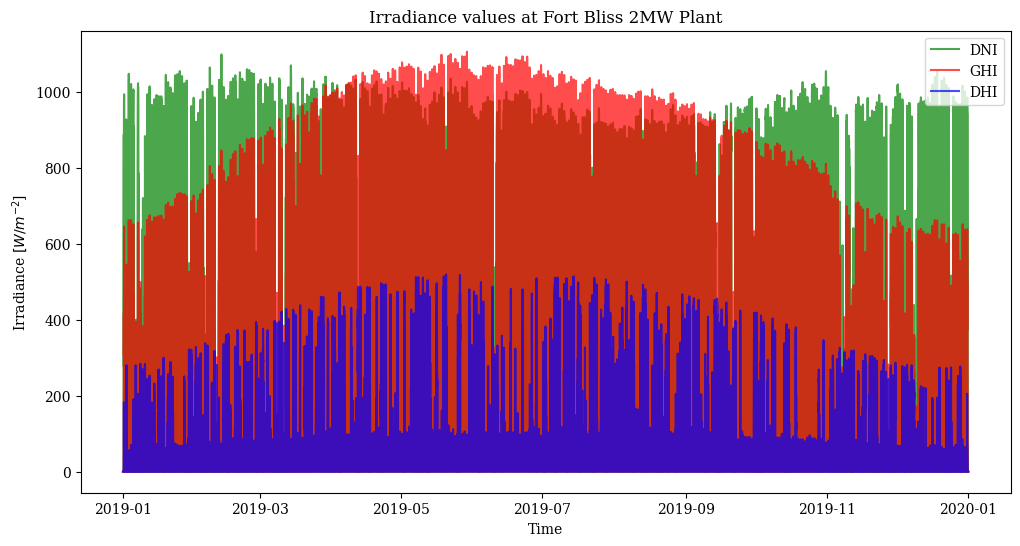

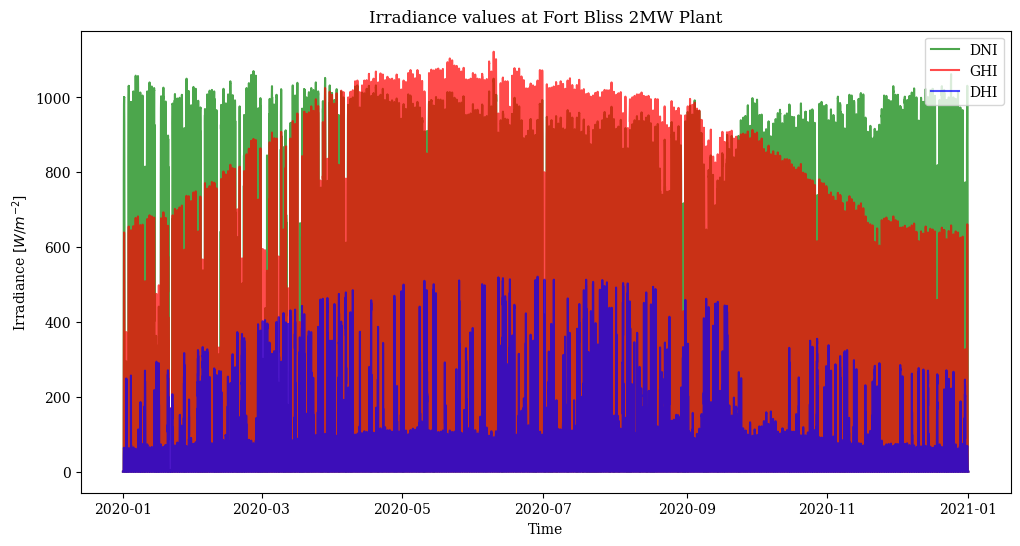

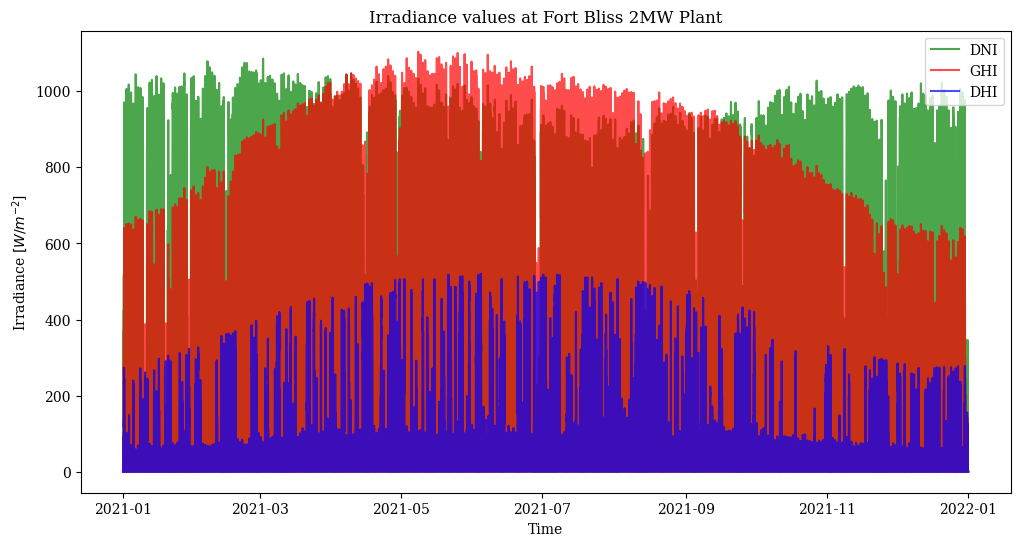

In [18]:
for year in [2019,2020,2021]:
    fort_psm3, fort_psm3_metadata = pvlib.iotools.get_psm3(FORTBLISS_ENERGY[0], FORTBLISS_ENERGY[1], api_key, email, interval=5, names=year, 
                                             map_variables=True, leap_day=True, attributes=('air_temperature', 'dew_point', 'dhi', 'dni', 'ghi', 'surface_albedo', 'surface_pressure', 'wind_direction', 'wind_speed'))
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_title("Irradiance values at Fort Bliss 2MW Plant")
    ax.set_ylabel("Irradiance $[W/m^{-2}$]")
    ax.set_xlabel("Time")
    ax.plot(fort_psm3["dni"], alpha=0.7, color='g',label='DNI')
    ax.plot(fort_psm3["ghi"], alpha=0.7, color='r',label='GHI')
    ax.plot(fort_psm3["dhi"], alpha=0.7, color='b',label='DHI')
    ax.legend(loc='upper right')                                                                                        

<h3>Statistics</h3>

In [19]:
#fort_mw=np.array([])
#fort_mw=np.append(fort_mw,[fort_annual_production_list_2019,fort_annual_production_list_2020,fort_annual_production_list_2021])

In [20]:
#fortbliss_energy_mw['pvlib model']=fort_mw

<h3>Data Standardization</h3>

In [21]:
#fortbliss_model=fortbliss_energy_mw.values[:,1]
#fortbliss_actual=fortbliss_energy_mw.values[:,0]

In [22]:
# Compute Pearson correlation
#corr, _ = pearsonr(fortbliss_energy_mw['pvlib model'], fortbliss_energy_mw['Actual Production'])

#print(f"Pearson Correlation: {corr}")
# Compute Euclidean distance
#dist = euclidean(fortbliss_energy_mw['pvlib model'], fortbliss_energy_mw['Actual Production'])

#print(f"Euclidean Distance: {dist}")


In [23]:
file_path_ercot=r'C:\Users\lehri\Documents\GitHub\dust_solar_power\ERCOT'
ercot_dam_2019_path=os.path.join(file_path_ercot,"rpt.00013060.0000000000000000.DAMLZHBSPP_2019.xlsx")
ercot_rtm_2019_path=os.path.join(file_path_ercot,"rpt.00013061.0000000000000000.RTMLZHBSPP_2019.xlsx")

ercot_dam_2020_path=os.path.join(file_path_ercot,"rpt.00013060.0000000000000000.DAMLZHBSPP_2020.xlsx")
ercot_dam_2021_path=os.path.join(file_path_ercot,"rpt.00013060.0000000000000000.DAMLZHBSPP_2021.xlsx")

In [24]:
ercot_dam_2019=pd.read_excel(ercot_dam_2019_path, sheet_name=None, index_col=0)
ercot_rtm_2019=pd.read_excel(ercot_rtm_2019_path, sheet_name=None, index_col=0)
ercot_dam_2020=pd.read_excel(ercot_dam_2020_path, sheet_name=None, index_col=0)
ercot_dam_2021=pd.read_excel(ercot_dam_2021_path, sheet_name=None, index_col=0)

In [25]:
def concatenate_ercot_excel(full_ercot_excel):
    ercot_concatenated=pd.DataFrame()
    for month in full_ercot_excel.keys():
        ercot_concatenated=pd.concat([ercot_concatenated, full_ercot_excel[month]])
    return ercot_concatenated
def clean_ercot_excel(ercot_concatenated):
    ercot_cleaned=ercot_concatenated[ercot_concatenated['Settlement Point']=='LZ_WEST'].drop(['Settlement Point'],axis=1)
    ercot_cleaned.loc[ercot_cleaned['Hour Ending'] == '24:00', 'Hour Ending'] = '00:00'
    ercot_cleaned=ercot_cleaned.assign(Datetime=[f"{date} {str(hour)}" for date, hour in zip(ercot_cleaned.index, ercot_cleaned['Hour Ending'])])
    ercot_cleaned.set_index(ercot_cleaned['Datetime'],inplace=True,drop=True)
    ercot_cleaned.drop(columns=['Hour Ending','Datetime','Repeated Hour Flag'],inplace=True)
    ercot_cleaned.index=ercot_cleaned.index.astype("datetime64[ns]")
    return ercot_cleaned

In [26]:
ercot_dam_2019_all=concatenate_ercot_excel(ercot_dam_2019)
ercot_dam_2020_all=concatenate_ercot_excel(ercot_dam_2020)
ercot_dam_2021_all=concatenate_ercot_excel(ercot_dam_2021)

ercot_dam_2019_all=clean_ercot_excel(ercot_dam_2019_all)
ercot_dam_2020_all=clean_ercot_excel(ercot_dam_2020_all)
ercot_dam_2021_all=clean_ercot_excel(ercot_dam_2021_all)
allyearshourly=[ercot_dam_2019_all,ercot_dam_2020_all,ercot_dam_2021_all]

In [27]:
ercot_dam_2019_all_mean=ercot_dam_2019_all.resample('1D').mean()
ercot_dam_2020_all_mean=ercot_dam_2020_all.resample('1D').mean()
ercot_dam_2021_all_mean=ercot_dam_2021_all.resample('1D').mean()
allyears=[ercot_dam_2019_all_mean,ercot_dam_2020_all_mean,ercot_dam_2021_all_mean]

In [28]:
ercot_dam_2019_all_mean.iloc[:,0].max()

664.7016666666667

In [29]:
ercot_dam_2021_modified=ercot_dam_2021_all_mean
ercot_cutoff=ercot_dam_2019_all_mean.iloc[:,0].max()
ercot_dam_2021_modified[ercot_dam_2021_modified.iloc[:,0]>ercot_cutoff]=ercot_cutoff


In [30]:
fort_pvlib_models_names

['No Soiling', 'Soiling', 'Soiling with Cleaning']

In [31]:
model_generation_hourly=[nosoiling_hourly,soiling_hourly,soilingclean_hourly]

count=0
for model in model_generation_hourly:
    print(f"{fort_pvlib_models_names[count]}")
    cps=0
    revenue_total=0
    power_total=0
    price_period_avg=0
    for i in [0,1,2]:
        year_avg=allyearshourly[i]['Settlement Point Price'].mean()
        revenue=allyearshourly[i]['Settlement Point Price']*model[0][i].iloc[:,0]
        revenue_total+=revenue.sum()
        power_total+=model[0][i].iloc[:,0].sum()
        price_period_avg=(price_period_avg+year_avg).mean()
        print(f"Revenue in {i+2019} [$] ",revenue.sum().round(decimals=2))
        print(f"Power in {i+2019} [MWh] ", model[0][i].iloc[:,0].sum().round(decimals=2))
   
    print(f"Total Revenue [$]: ",revenue_total.round(decimals=2))
    print(f"Total Power [MWh]: ",power_total.round(decimals=2))
    print("Average Mkt Price [$/MWh]:",price_period_avg.round(decimals=2))
    cps=revenue_total/power_total
    print(f"Capture Price Solar [$\$/MWh$]: ",(cps).round(decimals=2))
    print(f"Capture Rate Solar [$%$]: ",(cps/price_period_avg*100).round(decimals=2))
    print("______________")
    count+=1

No Soiling
Revenue in 2019 [$]  213559.31
Power in 2019 [MWh]  4923.08
Revenue in 2020 [$]  132739.2
Power in 2020 [MWh]  5109.09
Revenue in 2021 [$]  623507.32
Power in 2021 [MWh]  5021.04
Total Revenue [$]:  969805.82
Total Power [MWh]:  15053.2
Average Mkt Price [$/MWh]: 220.97
Capture Price Solar [$\$/MWh$]:  64.43
Capture Rate Solar [$%$]:  29.15
______________
Soiling
Revenue in 2019 [$]  175719.99
Power in 2019 [MWh]  4013.08
Revenue in 2020 [$]  87177.41
Power in 2020 [MWh]  3048.72
Revenue in 2021 [$]  546294.84
Power in 2021 [MWh]  3132.7
Total Revenue [$]:  809192.23
Total Power [MWh]:  10194.5
Average Mkt Price [$/MWh]: 220.97
Capture Price Solar [$\$/MWh$]:  79.38
Capture Rate Solar [$%$]:  35.92
______________
Soiling with Cleaning
Revenue in 2019 [$]  195207.39
Power in 2019 [MWh]  4503.78
Revenue in 2020 [$]  120641.04
Power in 2020 [MWh]  4607.98
Revenue in 2021 [$]  593167.64
Power in 2021 [MWh]  4542.01
Total Revenue [$]:  909016.07
Total Power [MWh]:  13653.77
Avera

In [32]:
'''
model_generation=[nosoiling_daily,soiling_daily,soilingclean_daily]

count=0
for model in model_generation:
    print(f"{fort_pvlib_models_names[count]}")
    cps=0
    revenue_total=0
    power_total=0
    price_period_avg=0
    for i in [0,1,2]:
        year_avg=allyears[i]['Settlement Point Price'].mean()
        revenue=allyears[i]['Settlement Point Price']*model[0][i].iloc[:,0]
        revenue_total+=revenue.sum()
        power_total+=model[0][i].iloc[:,0].sum()
        price_period_avg=(price_period_avg+year_avg).mean()
        print(f"Revenue in {i+2019} [$] ",revenue.sum().round(decimals=2))
        print(f"Power in {i+2019} [MWh] ", model[0][i].iloc[:,0].sum().round(decimals=2))
   
    print(f"Total Revenue [$]: ",revenue_total.round(decimals=2))
    print(f"Total Power [MWh]: ",power_total.round(decimals=2))
    print("Average Mkt Price [$/MWh]:",price_period_avg.round(decimals=2))
    cps=revenue_total/power_total
    print(f"Capture Price Solar [$\$/MWh$]: ",(cps).round(decimals=2))
    print(f"Capture Rate Solar [$%$]: ",(cps/price_period_avg*100).round(decimals=2))
    print("______________")
'''

'\nmodel_generation=[nosoiling_daily,soiling_daily,soilingclean_daily]\n\ncount=0\nfor model in model_generation:\n    print(f"{fort_pvlib_models_names[count]}")\n    cps=0\n    revenue_total=0\n    power_total=0\n    price_period_avg=0\n    for i in [0,1,2]:\n        year_avg=allyears[i][\'Settlement Point Price\'].mean()\n        revenue=allyears[i][\'Settlement Point Price\']*model[0][i].iloc[:,0]\n        revenue_total+=revenue.sum()\n        power_total+=model[0][i].iloc[:,0].sum()\n        price_period_avg=(price_period_avg+year_avg).mean()\n        print(f"Revenue in {i+2019} [$] ",revenue.sum().round(decimals=2))\n        print(f"Power in {i+2019} [MWh] ", model[0][i].iloc[:,0].sum().round(decimals=2))\n   \n    print(f"Total Revenue [$]: ",revenue_total.round(decimals=2))\n    print(f"Total Power [MWh]: ",power_total.round(decimals=2))\n    print("Average Mkt Price [$/MWh]:",price_period_avg.round(decimals=2))\n    cps=revenue_total/power_total\n    print(f"Capture Price Solar

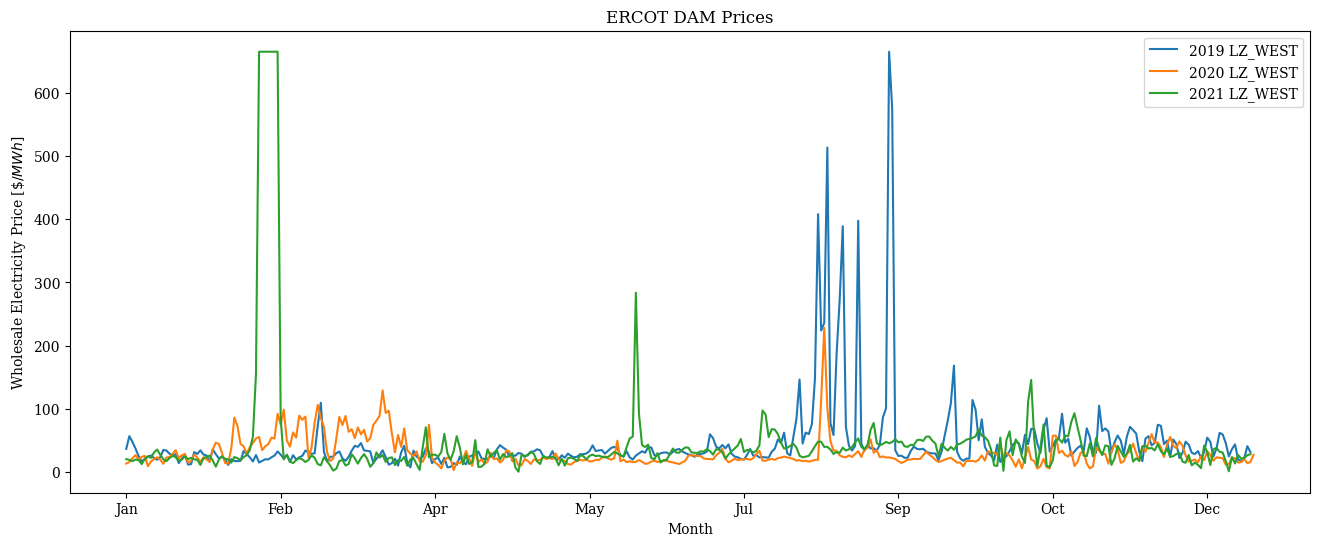

In [33]:
fig,ax = plt.subplots(figsize=(16, 6))
#ercot_dam_2019_zone_2=ercot_dam_2019[ercot_dam_2019['Settlement Point']=='HB_WEST'].drop(['Settlement Point'],axis=1)
ax.set_title('ERCOT DAM Prices')
for year in [2019,2020,2021]:
    date_index=pd.date_range(start=f"{year}-01-01",end=f"{year+1}-01-01",freq="1D")[:-1]
    if year==2021:
        ax.plot(ercot_dam_2021_modified.values, label=f'{year} LZ_WEST')
    else:
        ax.plot(allyears[year-2019].values, label=f'{year} LZ_WEST')
    ax.set_ylabel("Wholesale Electricity Price [$\$/MWh$]")
    ax.set_xlabel("Month")
    #ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1,13,1)))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    #plt.xticks(np.arange(12),calendar.month_name[1:])
    #ax.plot(ercot_dam_2020_all, label='2020 LZ_WEST')
    #ax.plot(ercot_dam_2021_all, label='2021 LZ_WEST')
    ax.legend(loc='upper right')
